In [1]:
!pip install -q transformers datasets torch torchvision albumentations matplotlib load_dotenv
!pip install -q -U "huggingface_hub[cli]"


In [2]:
from dotenv import load_dotenv
import os
# Load environment variables from a file named '.env' in the same directory
load_dotenv()

HUGGINGFACE_TOKEN = os.environ['HUGGINGFACE_TOKEN']
!huggingface-cli login --token $HUGGINGFACE_TOKEN --add-to-git-credential


Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# !huggingface-cli download doc2txt/tbl-unet --local-dir tbl-unet

# init

In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch.nn as nn
import torchvision
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm
import time

BASE_PATH = "../pdfBLines/tblDS/"
# BASE_PATH = "/home/ubuntu/work/carvana/dataset/"
CHECKPOINT_PATH = "./tbl-unet/tbl_dice1.00.pth.tar"


# Hyperparameters etc.
LEARNING_RATE = 3e-4 # Andrej Karpathy LR
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("DEVICE", DEVICE)
BATCH_SIZE = 4
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 512 
IMAGE_WIDTH = 512  
PIN_MEMORY = True
LOAD_MODEL = False
WEIGHT_DECAY = 0 # 1e-4


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:

class TblDataset(Dataset):
    def __init__(self, root_dir, transform=None):     
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = os.listdir(self.root_dir)    
        self.images = list(filter(lambda x: "_src.jpg" in x, self.images))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.images[index])
        mask_path = os.path.join(self.root_dir, self.images[index].replace("_src.jpg", "_mask.png"))
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        image = image.resize(mask.size)
        # mask = mask.resize(image.size)
        image = np.array(image, dtype=np.float32)
        image = image / 255.0
        mask = np.array(mask, dtype=np.float32)
        mask[mask != 255] = 0
        mask[mask == 255] = 1.0
        
        image1,mask1 = image,mask
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image1 = augmentations['image']
            # assert image1.shape == image.shape, f"{ image1.shape},  {image.shape}"
            mask1 = augmentations['mask']
        
            
        return image1,mask1
    
root_dir=os.path.join(BASE_PATH,"train")
images = os.listdir(root_dir)   
images1 = list(filter(lambda x: "_src.jpg" in x, images))
len(images1)        

1127

In [3]:
root_dir=os.path.join(BASE_PATH,"train")
images = os.listdir(root_dir)   
images1 = list(filter(lambda x: "_src.jpg" in x, images))
len(images1)

1127

In [4]:
train_transform = A.Compose(
    [
        A. Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A. Rotate(limit=2.5, p=0.5),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)


In [5]:
UnetDataset = TblDataset
train_ds = UnetDataset(
    root_dir=os.path.join(BASE_PATH,"train"),
    transform=train_transform,
)
print(os.path.join(BASE_PATH,"train"))
train_loaders = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    # num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)
print(len(train_ds))
# val_ds = UnetDataset(
#     root_dir=os.path.join(BASE_PATH,"valid"),

#     transform=val_transform,
# )
# val_loaders = DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     pin_memory=PIN_MEMORY,
#     shuffle=False,
# )
for batch in train_loaders:
    images, masks = batch
    break
print("images.shape", images.shape)
print("masks.shape", masks.shape)
data, targets = next(iter(train_loaders))
print ("data.dtype", data.dtype)
print ("targets.dtype", targets.dtype)

../pdfBLines/tblDS/train
1127
images.shape torch.Size([4, 1, 512, 512])
masks.shape torch.Size([4, 512, 512])
data.dtype torch.float32
targets.dtype torch.float32


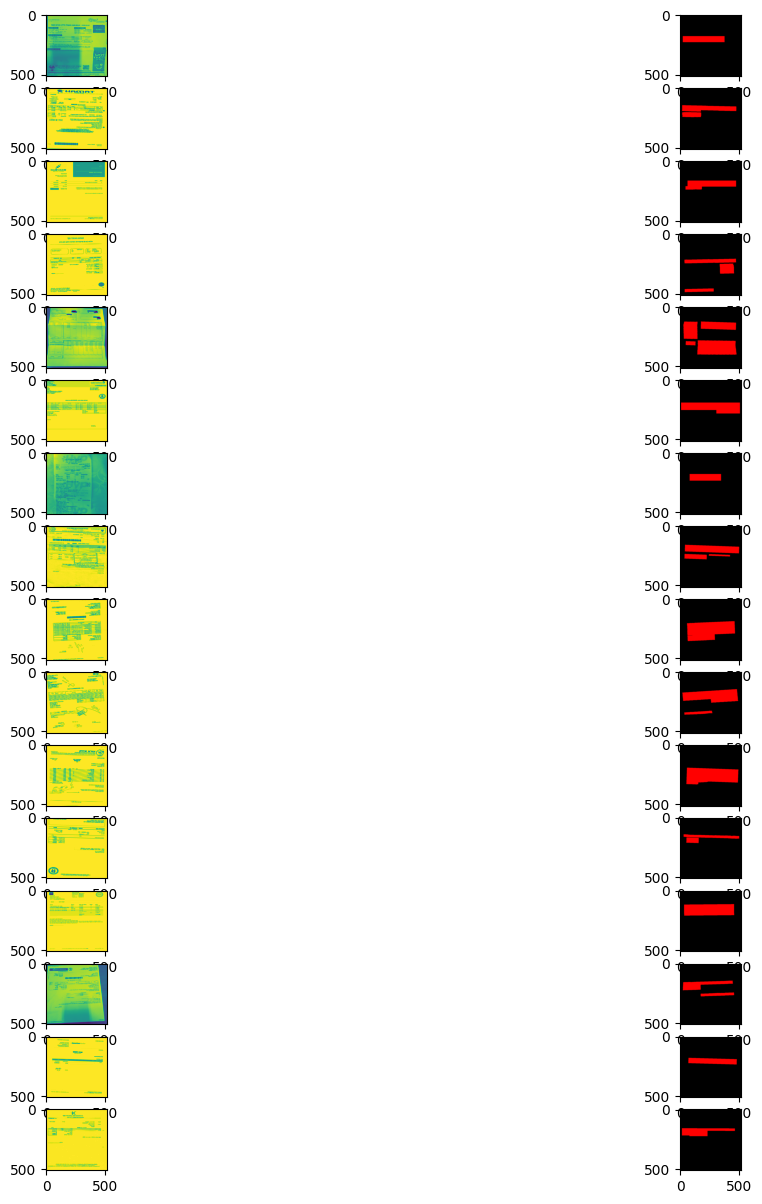

In [6]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in train_loaders:
    images, masks = batch
    break

n_plots = BATCH_SIZE
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)

for i in range(n_plots):
    image =images[i,:,:].permute(1, 2, 0)
    axarr[i,0].imshow(image)
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

# Unet model

In [6]:
from torch import nn
from torch import cat
import numpy as np
# import cfg



class LFUNet(nn.Module):
    def __init__(self,in_channels=1, num_class=1):
        super().__init__()

        n = 8
        g = 8
        # x0.0 => out chanel = 8
        self.stage00 = nn.Sequential(
            nn.Conv2d(  in_channels,  n, kernel_size=3, stride=1, padding=1, groups=1), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1, groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x1.0 => out chanel = 8*2 = 16
        self.stage10 = nn.Sequential(
            nn.Conv2d(  n, 2*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(2*n), nn.ReLU(inplace=True),
            nn.Conv2d(2*n, 2*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(2*n), nn.ReLU(inplace=True),
        ) 
        # x2.0 => out chanel = 8*4 = 32
        self.stage20 = nn.Sequential(
            nn.Conv2d(2*n, 4*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(4*n), nn.ReLU(inplace=True),
            nn.Conv2d(4*n, 4*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(4*n), nn.ReLU(inplace=True),
        )
        # x3.0 => out chanel = 8*8 = 64
        self.stage30 = nn.Sequential(
            nn.Conv2d(4*n, 8*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(8*n), nn.ReLU(inplace=True),
            nn.Conv2d(8*n, 8*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(8*n), nn.ReLU(inplace=True),
        )
        # x4.0 => out chanel = 8*16 = 128
        self.stage40 = nn.Sequential(
            nn.Conv2d( 8*n, 16*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(16*n), nn.ReLU(inplace=True),
            nn.Conv2d(16*n, 16*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(16*n), nn.ReLU(inplace=True),
        )

        # x0.1 
        self.stage01 = nn.Sequential(
            nn.Conv2d(2*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x1.1
        self.stage11 = nn.Sequential(
            nn.Conv2d(3*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x0.2
        self.stage02 = nn.Sequential(
            nn.Conv2d(4*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x2.1
        self.stage21 = nn.Sequential(
            nn.Conv2d(4*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x1.2
        self.stage12 = nn.Sequential(
            nn.Conv2d(5*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x0.3
        self.stage03 = nn.Sequential(
            nn.Conv2d(6*n,   n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,   n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x3.1
        self.stage31 = nn.Sequential(
            nn.Conv2d(5*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x2.2
        self.stage22 = nn.Sequential(
            nn.Conv2d(6*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x1.3
        self.stage13 = nn.Sequential(
            nn.Conv2d(7*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x0.4
        self.stage04 = nn.Sequential(
            nn.Conv2d(8*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )


        # trans
        self.stage0p = nn.Sequential(nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage1p = nn.Sequential(nn.Conv2d(2*n,  n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage2p = nn.Sequential(nn.Conv2d(4*n,  n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage3p = nn.Sequential(nn.Conv2d(8*n,  n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage4p = nn.Sequential(nn.Conv2d(16*n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stagep = self.stage0p

        self.stage0zp = nn.Sequential(nn.Conv2d(n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage1zp = nn.Sequential(nn.Conv2d(2 * n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage2zp = nn.Sequential(nn.Conv2d(4 * n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage3zp = nn.Sequential(nn.Conv2d(8 * n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage4zp = nn.Sequential(nn.Conv2d(16 * n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stagezp = self.stage0zp

        # down-sampling
        self.stage2d = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2zd = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))
        self.stage4zd = nn.Sequential(nn.MaxPool2d(kernel_size=4, stride=4))
        self.stage8zd = nn.Sequential(nn.MaxPool2d(kernel_size=8, stride=8))

        # up-sampling
        self.stage2u = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))
        self.stage4u = nn.Sequential(nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True))
        self.stage8u = nn.Sequential(nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True))
        self.stage16u = nn.Sequential(nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True))

        # output
        self.stageout = nn.Sequential(
            nn.Conv2d(  n, num_class, 1 ,groups=1)
        )


    def forward(self, x):
        s00 = self.stage00(x) # out chanel = 8
        s10 = self.stage10(self.stage2d(s00)) # out chanel = 16
        s01 = self.stage01(cat([self.stage0p(s00), # out chanel = 8
                                self.stage1p(self.stage2u(s10))], 1))

        s20 = self.stage20(self.stage2d(s10))
        s11 = self.stage11(cat([self.stage0zp(self.stage2zd(s00)),
                                self.stage1p(s10),
                                self.stage2p(self.stage2u(s20))], 1))
        s02 = self.stage02(cat([self.stage0p(s00), self.stagezp(s01),
                                self.stage2zp(self.stage4u(s20)), self.stagep(self.stage2u(s11))], 1))

        s30 = self.stage30(self.stage2d(s20))
        s21 = self.stage21(cat([self.stage0zp(self.stage4zd(s00)), self.stage1zp(self.stage2zd(s10)),
                                self.stage2p(s20),
                                self.stage3p(self.stage2u(s30))], 1))
        s12 = self.stage12(cat([self.stage0zp(self.stage2zd(s00)),
                                self.stage1p(s10), self.stagezp(s11),
                                self.stage3zp(self.stage4u(s30)), self.stagep(self.stage2u(s21))], 1))
        s03 = self.stage03(
            cat([self.stage0p(s00), self.stagezp(s01), self.stagezp(s02),
                 self.stage3zp(self.stage8u(s30)), self.stagezp(self.stage4u(s21)), self.stagep(self.stage2u(s12))], 1))

        s40 = self.stage40(self.stage2d(s30))
        s31 = self.stage31(
            cat([self.stage0zp(self.stage8zd(s00)), self.stage1zp(self.stage4zd(s10)),
                 self.stage2zp(self.stage2zd(s20)),
                 self.stage3p(s30),
                 self.stage4p(self.stage2u(s40))], 1))
        s22 = self.stage22(cat([self.stage0zp(self.stage4zd(s00)), self.stage1zp(self.stage2zd(s10)),
                                self.stage2p(s20), self.stagezp(s21),
                                self.stage4zp(self.stage4u(s40)), self.stagep(self.stage2u(s31))], 1))
        s13 = self.stage13(
            cat([self.stage0zp(self.stage2zd(s00)),
                 self.stage1p(s10), self.stagezp(s11), self.stagezp(s12),
                 self.stage4zp(self.stage8u(s40)), self.stagezp(self.stage4u(s31)), self.stagep(self.stage2u(s22))], 1))
        s04 = self.stage04(
            cat([self.stage0p(s00), self.stagezp(s01), self.stagezp(s02), self.stagezp(s03),
                 self.stage4zp(self.stage16u(s40)), self.stagezp(self.stage8u(s31)),
                 self.stagezp(self.stage4u(s22)), self.stagep(self.stage2u(s13))], 1))

        out1 = self.stageout(s01)
        out2 = self.stageout(s02)
        out3 = self.stageout(s03)
        out4 = self.stageout(s04)
        # out = out1
        # out = (out1 + out2) / 2
        # out = (out1 + out2 + out3) / 3
        out = (out1 + out2 + out3 + out4) / 4

        return out

# Utils

In [7]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint",filename)
    torch.save(state, filename)

def check_accuracy(loader, model, device="cuda"):
    print("Checking accuracy")
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            acc = (preds == y).sum()
            numElem = torch.numel(preds)
            # print(idx, acc/numElem)
            
            num_correct += acc
            num_pixels += numElem
            dice_score += (2*(preds*y).sum())/(
                (preds+y).sum() + 1e-8
            )

        print(
            f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
        )

        dice = dice_score/len(loader)
        print(f"Dice score: {dice}")

        model.train()
    return dice


def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    print("Saving predictions")
    start = time.time()
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, os.path.join(folder,f"pred_{idx}.png")
        )
        torchvision.utils.save_image(y.unsqueeze(1), 
                                    os.path.join(folder,f"correct_{idx}.png")
                                     )
    print(f"Saved predictions in {time.time()-start:.2f} seconds")
    model.train()


# Train

In [8]:
model = LFUNet(in_channels=1).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

In [9]:
load_checkpoint(
    CHECKPOINT_PATH, model, optimizer, LEARNING_RATE
)

=> Loading checkpoint


In [25]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    losses = []
    mean_loss =1
    for batch_idx, (data, targets) in enumerate(loop):
    # for i in range(10):
    #     data, targets = next(iter(loader))
        
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # print("loss", loss.item())

        # update tqdm
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)
    return mean_loss

In [26]:
# pos_weight = torch.ones([224]).to(DEVICE)
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = DiceLoss()

scaler = torch.cuda.amp.grad_scaler.GradScaler()
for epoch in range(NUM_EPOCHS):
    print("epoch", epoch)
    mean_loss = train_fn(train_loaders, model, optimizer, loss_fn, scaler)





    # print some example to folder
    if epoch % 10 == 0 and epoch>0:
        # save model
        check_point = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        # dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
        # save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score}.pth.tar"))        
        # save_predictions_as_imgs(
        #     val_loaders, model, folder="save_images/", device=DEVICE
        # )


epoch 0


100%|██████████| 71/71 [04:55<00:00,  4.16s/it, loss=0.689]


epoch 1


100%|██████████| 71/71 [04:55<00:00,  4.16s/it, loss=0.646]


epoch 2


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.607]


epoch 3


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.568]


epoch 4


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.527]


epoch 5


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.488]


epoch 6


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.454]


epoch 7


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.425]


epoch 8


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.397]


epoch 9


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.371]


epoch 10


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.351]


epoch 11


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.332]


epoch 12


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.316]


epoch 13


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.301]


epoch 14


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.286]


epoch 15


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.275]


epoch 16


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.264]


epoch 17


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.256]


epoch 18


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.249]


epoch 19


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.243]


epoch 20


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.236]


epoch 21


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.231]


epoch 22


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.226]


epoch 23


100%|██████████| 71/71 [04:55<00:00,  4.16s/it, loss=0.221]


epoch 24


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.215]


epoch 25


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.211]


epoch 26


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.207]


epoch 27


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.202]


epoch 28


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.2]  


epoch 29


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.194]


epoch 30


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.191]


epoch 31


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.188]


epoch 32


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.186]


epoch 33


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.182]


epoch 34


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.179]


epoch 35


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.177]


epoch 36


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.174]


epoch 37


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.171]


epoch 38


100%|██████████| 71/71 [04:55<00:00,  4.16s/it, loss=0.169]


epoch 39


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.167]


epoch 40


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.164]


epoch 41


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.161]


epoch 42


100%|██████████| 71/71 [04:55<00:00,  4.16s/it, loss=0.16] 


epoch 43


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.158]


epoch 44


100%|██████████| 71/71 [04:55<00:00,  4.16s/it, loss=0.157]


epoch 45


100%|██████████| 71/71 [04:55<00:00,  4.17s/it, loss=0.155]


epoch 46


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.153]


epoch 47


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.152]


epoch 48


100%|██████████| 71/71 [04:55<00:00,  4.16s/it, loss=0.15] 


epoch 49


100%|██████████| 71/71 [04:57<00:00,  4.19s/it, loss=0.15] 


epoch 50


100%|██████████| 71/71 [04:56<00:00,  4.18s/it, loss=0.149]


epoch 51


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.147]


epoch 52


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.144]


epoch 53


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.143]


epoch 54


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.142]


epoch 55


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.144]


epoch 56


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.14] 


epoch 57


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.139]


epoch 58


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.138]


epoch 59


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.139]


epoch 60


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.136]


epoch 61


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.134]


epoch 62


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.135]


epoch 63


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.133]


epoch 64


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.133]


epoch 65


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.133]


epoch 66


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.131]


epoch 67


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.13] 


epoch 68


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.129]


epoch 69


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.129]


epoch 70


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.127]


epoch 71


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.127]


epoch 72


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.126]


epoch 73


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.127]


epoch 74


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.125]


epoch 75


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.123]


epoch 76


100%|██████████| 71/71 [04:52<00:00,  4.13s/it, loss=0.125]


epoch 77


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.122]


epoch 78


100%|██████████| 71/71 [04:58<00:00,  4.20s/it, loss=0.12] 


epoch 79


100%|██████████| 71/71 [04:57<00:00,  4.19s/it, loss=0.12] 


epoch 80


100%|██████████| 71/71 [04:54<00:00,  4.15s/it, loss=0.12] 


epoch 81


100%|██████████| 71/71 [04:54<00:00,  4.14s/it, loss=0.121]


epoch 82


100%|██████████| 71/71 [04:53<00:00,  4.13s/it, loss=0.119]


epoch 83


100%|██████████| 71/71 [04:57<00:00,  4.18s/it, loss=0.119]


epoch 84


100%|██████████| 71/71 [04:55<00:00,  4.17s/it, loss=0.118]


epoch 85


100%|██████████| 71/71 [04:57<00:00,  4.19s/it, loss=0.117]


epoch 86


100%|██████████| 71/71 [04:57<00:00,  4.19s/it, loss=0.116]


epoch 87


100%|██████████| 71/71 [04:56<00:00,  4.18s/it, loss=0.117]


epoch 88


100%|██████████| 71/71 [04:57<00:00,  4.18s/it, loss=0.115]


epoch 89


100%|██████████| 71/71 [04:57<00:00,  4.18s/it, loss=0.114]


epoch 90


100%|██████████| 71/71 [04:52<00:00,  4.12s/it, loss=0.114]


epoch 91


100%|██████████| 71/71 [04:51<00:00,  4.11s/it, loss=0.112]


epoch 92


100%|██████████| 71/71 [04:52<00:00,  4.13s/it, loss=0.114]


epoch 93


100%|██████████| 71/71 [04:57<00:00,  4.19s/it, loss=0.114]


epoch 94


100%|██████████| 71/71 [04:56<00:00,  4.18s/it, loss=0.112]


epoch 95


100%|██████████| 71/71 [04:57<00:00,  4.19s/it, loss=0.112]


epoch 96


100%|██████████| 71/71 [04:53<00:00,  4.14s/it, loss=0.11] 


epoch 97


100%|██████████| 71/71 [04:52<00:00,  4.11s/it, loss=0.111]


epoch 98


100%|██████████| 71/71 [04:56<00:00,  4.18s/it, loss=0.112]


epoch 99


100%|██████████| 71/71 [04:56<00:00,  4.18s/it, loss=0.111]


In [27]:
# dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
save_checkpoint(check_point, CHECKPOINT_PATH)        
# save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score:.2F}.pth.tar"))        
COMMIT_MSG = f"from scrach IMAGE_HEIGHT {IMAGE_HEIGHT} BATCH_SIZE {BATCH_SIZE} epoch {epoch} loss {mean_loss} Transform rotate 2.5 only line tbls"


=> Saving checkpoint ./tbl-unet/tbl_dice1.00.pth.tar


In [28]:
!echo "$COMMIT_MSG"

from scrach IMAGE_HEIGHT 512 BATCH_SIZE 16 epoch 99 loss 0.11051885426883966 Transform rotate 2.5 only line tbls


In [29]:
!huggingface-cli upload doc2txt/tblSrc-LFUnet ./tbl-unet . --commit-message="$COMMIT_MSG"

Consider using `hf_transfer` for faster uploads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
/opt/conda/lib/python3.10/site-packages/huggingface_hub/hf_api.py:3757: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
tbl_dice1.00.pth.tar: 100%|██████████████████| 769k/769k [00:00<00:00, 1.27MB/s]
https://huggingface.co/doc2txt/tblSrc-LFUnet/tree/main/.


In [ ]:
# model = model.half()

 # view results

In [10]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}
def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8).squeeze())

In [11]:

for idx, (pixel_values,masks) in enumerate(train_loaders):
# for idx, (pixel_values,masks) in enumerate(val_loaders):
    pixel_values = pixel_values.to(DEVICE)
    # pixel_values = pixel_values.half()
    print(idx, pixel_values.shape)
    preds = torch.sigmoid(model(pixel_values))
    print(idx, preds.shape)
    
    preds = (preds > 0.5).float()
    print(idx, preds.shape)
    
    masks = masks.cpu().numpy()
    break # only one batch
predicted_mask = preds.cpu()
del preds

0 torch.Size([4, 1, 512, 512])
0 torch.Size([4, 1, 512, 512])
0 torch.Size([4, 1, 512, 512])


In [13]:
print("predicted_mask.shape",predicted_mask.shape)
print("masks.shape",masks.shape)

predicted_mask.shape torch.Size([4, 1, 512, 512])
masks.shape (4, 512, 512)


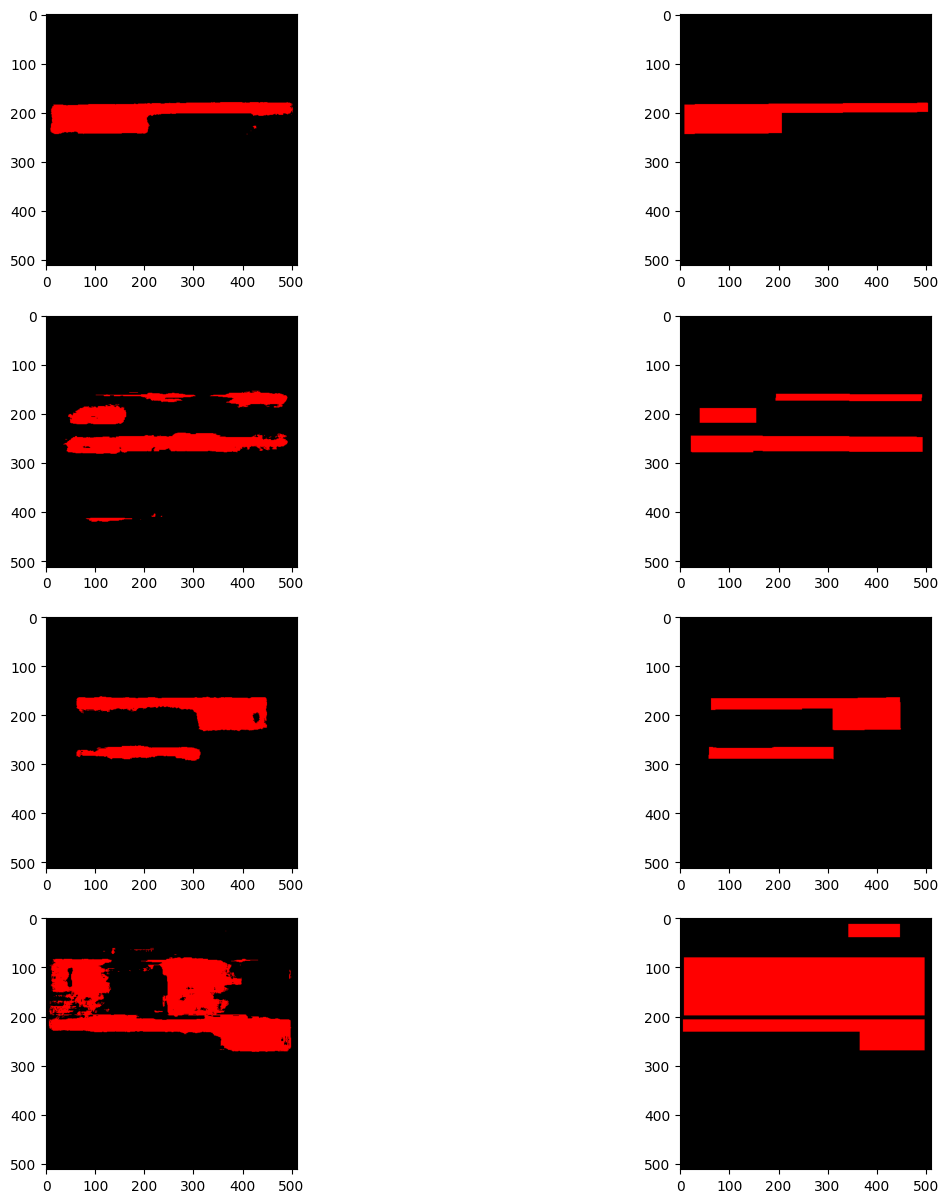

In [12]:



n_plots = 4
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

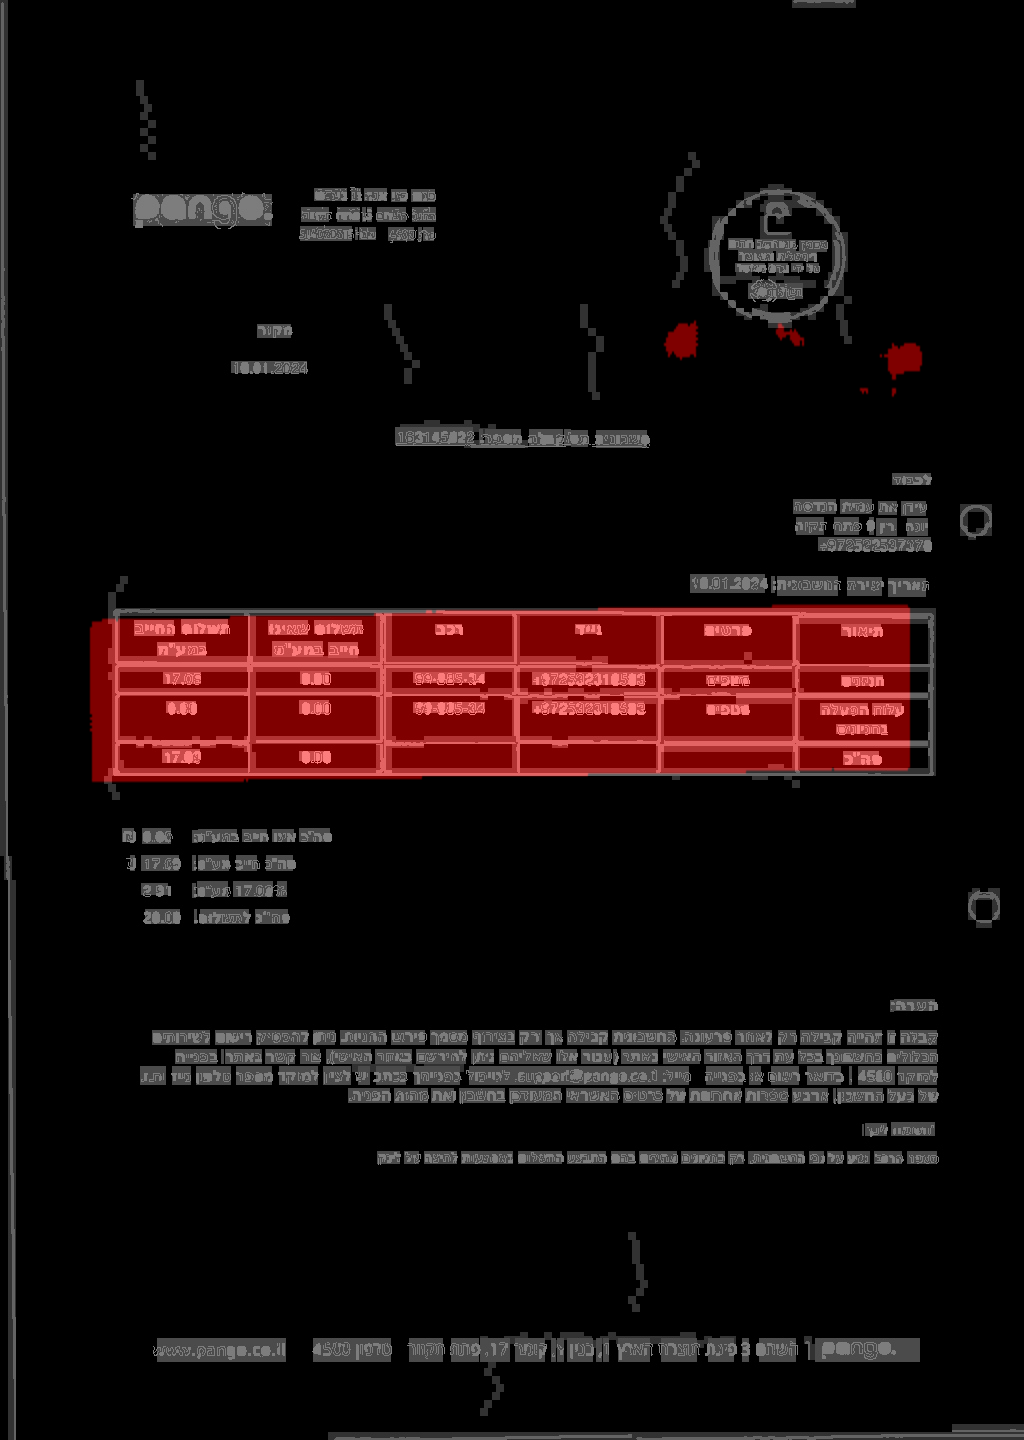

In [12]:
#Predict on a test image and overlay the mask on the original image
ds = train_ds
test_idx = 0
input_image_file = os.path.join(ds.root_dir,ds.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = ds[test_idx]
images, masks = test_batch
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
images= images.to(DEVICE)
# outputs = model(images.half())
outputs = model(images)
preds = torch.sigmoid(outputs)
predicted_mask = (preds > 0.5).float()


mask = prediction_to_vis(predicted_mask[test_idx,:,:].cpu())
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)
overlay_img